# Physics-Informed Neural Networks for the solution of 1 dimensional Equations

In [10]:
import os
# Surpress unnecessary output from tensorflow package
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import necessary functions/ packages
from PINNLearning.data import gen_data, set_boundaries, simp_sol, simp_sim, add_noise
from PINNLearning.training import learning_rate_schedule, train, oneD_loss
from PINNLearning.models import create_model
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import keras

We first need to set some global values and settings:

In [2]:
# Plot settings
plt.close('all')
plt.rcParams['font.family'] = 'Ubuntu Nerd Font'
plt.rcParams['font.size'] = 10

# Dimensions of the simulation space
lower_bound = 0.0
upper_bound = 1.0

## Initial Testing with boundary conditions

We aim to solve the heat equation:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

To simplify the problem, we make the following assumptions:
- The diffusion factor $\alpha$ is set to a constant value of 1
- Time dependency is ignored, leading to: $u(x, t) = u(x)$
- The function is one dimensional, so: $\Delta u(x, t) = \frac{d^2 u(x, t)}{d^2x}$


With these simplifications, the equation reduces to:

$u(x) = \dfrac{d^2}{dx^2} u(x)$

The problem is normalized over the range $[0,1]$, with Dirichlet boundary conditions specified as:

$u(0) = 1$ and $u(1) = 0$

These boundary conditions can easily be adjusted to Neumann boundary conditions by modifying the loss function used for training the PINN.

For comparative purposes, the analytical solution corresponding to the specified boundaries is given by:

$u(x) = \dfrac{e^{-x} (e^2-e^{2x})}{e^2-1}$

****
We are attempting to solve this equation using **Physics-Informed Neural Networks (PINNs)**. **PINNs** are a class of neural networks designed to solve differential equations by incorporating physical laws directly into the training process. Unlike traditional neural networks that rely solely on data, **PINNs** leverage both data and the governing equations of the physical system to enhance accuracy and generalization.

As illustrated in the image below (source: [Link](https://www.mathworks.com/discovery/physics-informed-neural-networks.html) [accessed 18 Jun 2025]), the implementation extends the loss function to include terms for the residuals from the given differential equation(s) and the boundary conditions, all computed in a consistent manner. The necessary derivatives can be computed _automatically_ by the algorithm that optimizes the network, as they are required for gradient-based optimization methods anyway.
Since a neural network can converge to only one solution for a given equation, and a differential equation typically describes multiple possible solutions, **at least either** the boundary values or measurement data must be provided to exclude all but one solution. 
It is possible to train the neural network in such a way that it can provide solutions for all boundary conditions. However, this requires modifications to the features entered into the network and the loss function. A closer examination of this option is provided in the notebook `Special Problems`.

In all subsequent implementations, the loss consists of **two terms** (residual and either data or boundaries) based on the **mean squared error (MSE)**, and the input to the neural network is always one-dimensional.

<img src="./data/images/PINN info.png" alt="Demonstration of PINNs" style="width:800px;"/>

The model is created using [Keras](https://keras.io) with [TensorFlow](https://www.tensorflow.org) (TF) as the backend. Therefore, all data entered into or returned from the model must be in the format of a _TF tensor_. 
To achieve this, the boundary conditions must first be converted into the corresponding tensor format.


Since the differential equation _fully_ describes our problem and _sufficient_ boundary conditions are provided, we can adopt an **unsupervised learning regime** (where data points only consist of x–values, with no corresponding true y–values). Accordingly, the training data can be generated across the problem space, either randomly or systematically, but it must ultimately be converted into a TF tensor. 
The **dimensions** of this tensor are crucial, as TF _automatically generates the input layer_ of the neural network based on these dimensions. TF uses a _row-major_ storage format, meaning that each **row** represents a separate data point and each **column** represents a separate input feature.


When creating the model, various hyperparameters can be adjusted, such as the learning rate, the number of epochs (or the minimum loss-improvement threshold), and the dimensions of the network itself.
For simple problems like this one, extensive adjustments are often unnecessary. However, for larger and more resource-intensive problems, tuning these hyperparameters can be vital for enhancing performance. An exemplary implementation of a **Hyperparameter Optimization (HPO) Algorithm** combined with a **Neural Architecture Search (NAS) Algorithm** can be found in the `HPO & NAS` notebook. For the initial problems addressed here, we will proceed without these optimizations.


In some cases, such as with the learning rate, _dynamically_ changing hyperparameters _during training_ can facilitate the convergence of the algorithm. This approach is known as **Dynamic Algorithm Configuration (DAC)**, which is implemented here as a learning rate schedule.
Finding the optimal start, stop, and step values can be approached in various ways. These include setting values heuristically (based on established rules or learned from the [meta features](https://www.sciencedirect.com/science/article/abs/pii/S0950705121011631) of the algorithm or dataset), incorporating these values as parameters in the **HPO** algorithm when treating the algorithm as a _black box_ (inputting data and only observing the output), or framing it as a separate Reinforcement Learning task for more intricate solutions, treating it as a _white box problem_ (leveraging information about the algorithm's internal state).
The latter option is a more advanced deep learning topic, as such no special consideration will be given to it in these notebooks; however, more information can be found [here](https://www.automl.org/dynamic-algorithm-configuration/).


For all implementations in this notebook, the code first checks if the model is already trained and stored in the `data` subdirectory. If this is the case, (re)training will be suspended (though it can be manually forced). Otherwise, the model will be automatically trained, and a loss-time development graph will be generated.

In [3]:
# Set the boundary conditions
x_bc, y_bc = set_boundaries([[0.0], [1.0]], [[1.0], [0.0]])

# Create the training data
x_train = gen_data(lower_bound, upper_bound, 100)

# Create the model with fixed sizes
model = create_model(3, 50)

# Create a learning rate schedule
# The purpose of which is to make learning more robust and increase speed
lr_schedule = learning_rate_schedule(1e-3, 1000, 0.9)

# Train the model if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model = keras.models.load_model('./data/simp_initial.keras')
except Exception as e:
    error_time = train(model, x_train, x_bc, y_bc, oneD_loss, lr_schedule, threshold=1e-8)
    model.save('./data/simp_initial.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    y_order = np.floor(np.log10(np.min(y)))
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(10**y_order, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()

Once the model has completed training, it needs to be tested against a more general case, referred to as **validation**. 
For this purpose, additional data points must be generated and evaluated across the problem space. Importantly, the points that the model was trained on must **NOT** be included in this validation set.


While this practice is particularly crucial for models that need to demonstrate strong generalization performance (which is not necessarily the case for models designed to return specific solutions to equations), it still serves as a valuable indicator of whether the model has been trained effectively on the data.


It is common to observe that the loss on the validation dataset is often higher than the final training loss. As long as the difference is not orders of magnitude apart, this still suggests that the model is performing well.

For further evaluation of the resulting model, the analytical solution is also inferred across the validation dataset. A graphical comparison of the results is presented below.

The loss over the validation data is: 2.446438656988903e-06


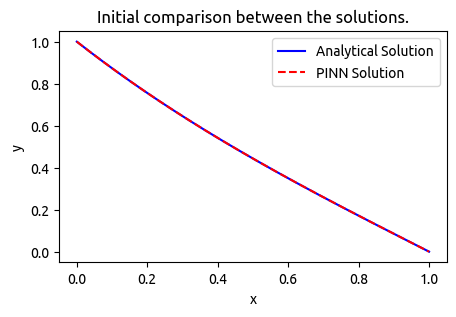

In [4]:
x_test = gen_data(lower_bound, upper_bound, 1000)

# Calculate the loss over the test data
val_loss = oneD_loss(model, x_test, x_bc, y_bc)
print(f"The loss over the validation data is: {val_loss}")

# Convert the returned Tf tensor to numpy for plotting
y_pred = model(x_test).numpy()
y_true = simp_sol(x_test)

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial comparison between the solutions.')
plt.show()

## Initial Equation without boundary conditions

In some situations, particularly in practical applications, the differential equations that _fully_ describe the problem may not be available, or not all necessary boundary conditions may be provided. 
However, as long as governing equations can be formulated, this situation can still be addressed.

To achieve this, the loss function must be adjusted to incorporate **real-world measurement data**.

This adjustment, however, introduces the challenge of **noise** in the training data and must be executed with care.

In the simplified problem described above, this situation is simulated by removing the boundary conditions and transitioning to a **supervised learning regime**, where all data points now contain both x-values and y-values.


The "measured" training data is collected by _sampling_ the y-values once from the analytical solution (resulting in ideal measurements with _no noise_) and once from an iterative finite-difference-based simulation (which produces _noisy_ measurements). Both sets of y-values are derived from the previously generated x-values in the training dataset. A comparison between these two data sources is shown below.


In this case, we will not be using a validation dataset, as the simulation cannot handle the increased number of data points within a reasonable time frame or with available resources.
This limitation is **not** an issue for the Physics-Informed Neural Network (PINN), which is a key reason why utilizing PINNs presents an interesting option.

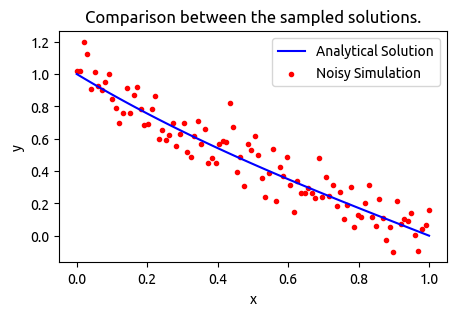

In [5]:
# Simulate the measurement data by generating 
# the different y-Values for the training data
y_train_sim, y_train_noisy = simp_sim(x_train, y_bc, noise_level=0.2)
y_train_true = simp_sol(x_train)
# FYI: As the y-values are only used to compute the loss and
# are thus not directly entered into the PINN, they do not
# need to be a Tf tensor!


plt.figure(figsize=(5, 3))
plt.plot(x_train, y_train_true, 'b', label="Analytical Solution")
plt.scatter(x_train, y_train_noisy, c='r', label='Noisy Simulation', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the sampled solutions.')
plt.show()

The training process is essentially a repetition of the previous implementation.
However, there is a slight misuse in this approach. The loss for the boundary conditions is computed in the same manner as the loss for the training data, for this reason these data points are included in the training function below as the "boundary conditions."

The process is carried out equivalently for both datasets.

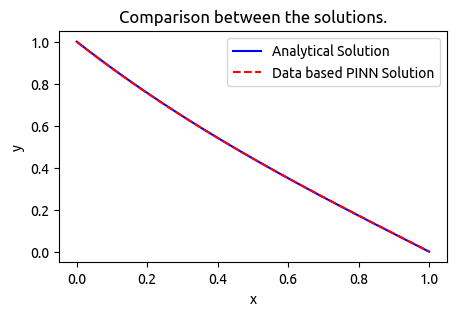

In [ ]:
# Create 2 models, one for each y-data
model2 = create_model(3, 50)
model3 = create_model(3, 50)


# Train the model for the true y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model2 = keras.models.load_model('./data/simp_data_true.keras')
except Exception as e:
    error_time = train(model2, x_train, x_train, y_train_true, oneD_loss, lr_schedule, threshold=1e-8)
    model2.save('./data/simp_data_true.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    y_order = np.floor(np.log10(np.min(y)))
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(10**y_order, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred2 = model2(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred2, 'r--', label='Data based PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

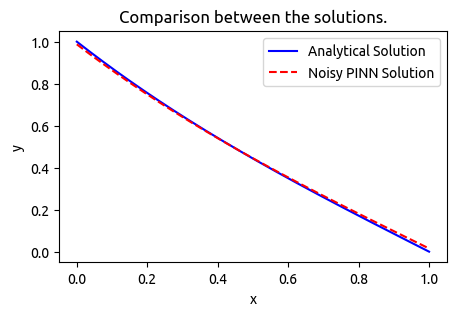

In [ ]:
# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model3 = keras.models.load_model('./data/simp_data_noisy.keras')
except Exception as e:
    error_time = train(model3, x_train, x_train, y_train_noisy, oneD_loss, lr_schedule, threshold=1e-8)
    model3.save('./data/simp_data_noisy.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    y_order = np.floor(np.log10(np.min(y)))
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(10**y_order, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred3 = model3(x_test).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_test, y_true, 'b-', label="Analytical Solution")
plt.plot(x_test, y_pred3, 'r--', label='Noisy PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

It is evident that the PINN trained on the ideal data perfectly models the analytical solution. This demonstrates that, using this approach, missing components of the differential equation or boundary conditions **can** be successfully compensated for.


Additionally, the model trained with noisy data still learned the function _adequately_. Experimenting with varying amounts of noise added to the data confirms that this holds true for **all** configurations.
This robustness stems from the choice of the loss term as **mean squared error (MSE)** and the **centering** of the noise around the true value. By utilizing this loss term, the differing error values tend to _cancel out_, provided there are enough measurement points and that these points are _distributed around_ the ideal solution.
For this reason, it is crucial that **all** measurements are **accurate** (though **not** necessarily **precise**, allowing for random noise), ensuring the absence of systematic errors, such as offsets.
As a general guideline, for _any_ statistically sound and robust evaluation (in this case, the model attempting to learn the underlying function), a minimum of _more than_ 30 samples from the population (measurement points) should be provided. However, since machine learning typically benefits significantly from larger datasets, it is strongly advisable to increase this number.


When comparing both resulting models, it is often observed that the one trained on noisy data exhibits a **larger** remaining error value. The percentage error of the "True Solution" can be expected to be roughly ten times smaller (close to **$0\%$**) than that of the model trained on noisy data.
In this specific configuration, with the set noise level and number of data points, the latter shows a percentage error of **$2.7\% \pm 1.1\%$**, as indicated by the statistical evaluation below.
This error is _expected_ to improve with an increasing number of data points. However, the enhanced accuracy of the model must be balanced against the effort required to obtain additional measurements and the **need** for this increase in the given application.


**Therefore, it is important to consider the error in the "predicted" values inferred from the PINN for all further applications.**

In [ ]:
# Compare the percentage error between the two trained models above

# Compute some numbers for comparison between these methods
err2 = y_true - y_pred2
err3 = y_true - y_pred3

# Get the max. and mean absolute error for each model
mae2 = np.mean(abs(err2))
max2 = max(abs(err2))[0]

mae3 = np.mean(abs(err3))
max3 = max(abs(err3))[0]

# Calculate the normalized mae as percentage error
mape2 = 100 * mae2/np.mean(y_true)
mape3 = 100 * mae3/np.mean(y_true)

# Print the comparison results nicely
sign1 = '>' if mae2 > mae3 else '<'
sign2 = '>' if max2 > max3 else '<'

print(20*" " + "True Solution" + 18 * " " + "Noisy Solution")
print(f"Average Error: {mae2} ({mape2:.2f}%)" + 2*" " + sign1 + f" {mae3} ({mape3:.2f}%)")
print(f"Maximum Error: {max2}" + 10*" " + sign2 + f" {max3}")

                    True Solution                  Noisy Solution
Average Error: 0.0006284255068749189 (0.14%)  < 0.006897184997797012 (1.49%)
Maximum Error: 0.0012981281615793705          < 0.015179391019046307


In [38]:
# Statistically evaluate the percentage error of the model traind on the nosy data

# Wrapper for the training of the individual models
def train_model(i):
    mod = create_model(3, 50)
    y_data = add_noise(y_train_sim, 0.2)
    train(mod, x_train, x_train, y_data, oneD_loss, lr_schedule, threshold=1e-8, write=False)
    print(f"Run {i + 1} completed!")
    return mod(x_test).numpy()

num_models = 32  # Number of models to be trained
# FYI: should be at least 30 for statistically reliable results
num_jobs = 8  # How many should be trained in parallel
#FYI: should not be higher than num of CPU cores!

# Parallelize the training to reduce training time
tasks = [delayed(train_model)(i) for i in range(num_models)]
y_pred_quant = list(Parallel(num_jobs)(tasks))

# Evaluate the pervemtage error for all models
for i in range(len(y_pred_quant)):
    err = y_true - y_pred_quant[i]
    y_pred_quant[i] = 100 * np.mean(abs(err))/np.mean(y_true)

print(f"The quantified error: {np.mean(y_pred_quant):.4f}% ± {np.std(y_pred_quant):.2f}%")

Last Epoch 685: last Loss = 0.009803157299757004
Run 3 completed!
Last Epoch 911: last Loss = 0.01117929071187973
Run 2 completed!
Last Epoch 984: last Loss = 0.007256506942212582
Run 5 completed!
Last Epoch 1496: last Loss = 0.009064977057278156
Run 4 completed!
Last Epoch 1494: last Loss = 0.010881704278290272
Run 8 completed!
Last Epoch 1550: last Loss = 0.008843912743031979
Run 6 completed!
Last Epoch 1563: last Loss = 0.008807748556137085
Run 1 completed!
Last Epoch 929: last Loss = 0.0117070646956563
Run 9 completed!
Last Epoch 1698: last Loss = 0.009502447210252285
Run 7 completed!
Last Epoch 193: last Loss = 0.011615989729762077
Run 16 completed!
Last Epoch 1299: last Loss = 0.00793843250721693
Run 10 completed!
Last Epoch 729: last Loss = 0.009022035636007786
Run 15 completed!
Last Epoch 1461: last Loss = 0.009477119892835617
Run 11 completed!
Last Epoch 1011: last Loss = 0.01171802170574665
Run 12 completed!
Last Epoch 1098: last Loss = 0.011575199663639069
Run 13 completed!


## Changing material conditions

We continue to solve the heat equation using the same simplifications as before:

$\dfrac{\partial u(x, t)}{\partial t} = \alpha \cdot \Delta u(x, t)$

However, we now consider the material to be inhomogeneous and non-isotropic. To accommodate this, the previously constant diffusion factor $\alpha$ must be generalized to $\alpha(x)$.

Thus, the equation we aim to solve becomes:

$u(x) = \alpha(x) \dfrac{d^2}{dx^2} u(x)$

We will maintain the same boundary conditions as before:

$u(0) = 1$ and $u(1) = 0$


Since we expect $\alpha(x)$ to be any kind of function, an analytical solution can no longer be computed. Instead, we will simulate the solution to this differential equation using the same iterative scheme as in the previous task set.
The necessary modifications to the neural network training scheme are limited to a minor adjustment of the loss function.


For comparative purposes, the $\alpha(x)$ we are discussing represents a simple switch in diffusivity from 1 to 0 across the normalized problem space. This is implemented in two ways: once using a **discontinuous** step function and once using a **smooth** sigmoid function.

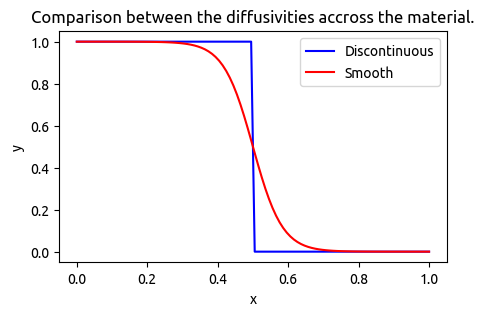

In [7]:
# Create the diffusion distributions accross the material

# the discontinuous change of material diffusivity
def alph_discon(x):
    # step function, adding 1e-6 to prevent deviding by 0
    return np.where(x < 0.5, upper_bound, lower_bound + 1e-6)

# smooth change of material diffusivity
def alph_smooth(x, k=24):
    # inverted sigmoid function, automatiaclly in [0, 1]
    sigmoid = 1 / (1 + np.exp(k * (x - 0.5)))
    # make sure the result is not too small peventing overflow
    if np.min(sigmoid) <= 1e-6:
        print("WARNING: Possible Overflow, sigmoid is too small.")
    return sigmoid


# draw both for visual comparison
data = np.linspace(0, 1, 100)
data_disc = alph_discon(data)
data_smooth = alph_smooth(data)

plt.figure(figsize=(5, 3))
plt.plot(data, data_disc, 'b', label="Discontinuous")
plt.plot(data, data_smooth, c='r', label='Smooth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the diffusivities accross the material.')
plt.show()

Epoch 100: Loss = 0.023634307086467743
Epoch 200: Loss = 0.022875340655446053
Epoch 300: Loss = 0.02263845130801201
Epoch 400: Loss = 0.02249307930469513
Epoch 500: Loss = 0.022354837507009506
Epoch 600: Loss = 0.02218892239034176
Epoch 700: Loss = 0.021983079612255096
Epoch 800: Loss = 0.021755008026957512
Epoch 900: Loss = 0.02153635583817959
Epoch 1000: Loss = 0.021373309195041656
Epoch 1100: Loss = 0.021225472912192345
Epoch 1200: Loss = 0.02107693813741207
Epoch 1300: Loss = 0.020895270630717278
Epoch 1400: Loss = 0.021618710830807686
Epoch 1500: Loss = 0.020280009135603905
Epoch 1600: Loss = 0.019695304334163666
Epoch 1700: Loss = 0.018938692286610603
Epoch 1800: Loss = 0.017337005585432053
Epoch 1900: Loss = 0.009309989400207996
Epoch 2000: Loss = 0.006221332587301731
Last Epoch 2039: last Loss = 0.00572834350168705


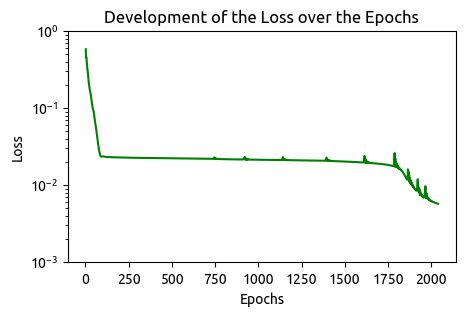

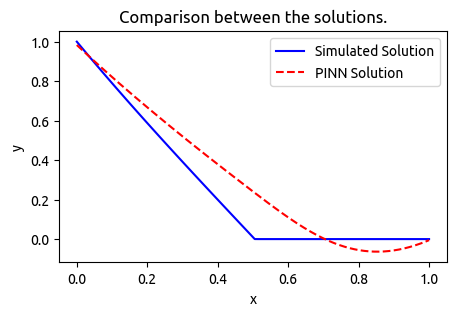

In [ ]:
# Train/Test the model in the disontinuous case

# Create a model
model4 = create_model(3, 50)

# Create closure function to set alpha and use same fitting function
def loss(model, inp, x_bc, y_bc):
    return oneD_loss(model, inp, x_bc, y_bc, alph_discon)


# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model4 = keras.models.load_model('./data/simp_mat_var_disc.keras')
except Exception as e:
    error_time = train(model4, x_train, x_bc, y_bc, loss, lr_schedule, threshold=1e-8)
    model4.save('./data/simp_mat_var_disc.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    y_order = np.floor(np.log10(np.min(y)))
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(10**y_order, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred4 = model4(x_test).numpy()
# Simulate y_true --> use x_train as this is smaller
y_true_sim = simp_sim(x_train, y_bc, alph=alph_discon)[0]

plt.figure(figsize=(5, 3))
plt.plot(x_train, y_true_sim, 'b-', label="Simulated Solution")
plt.plot(x_test, y_pred4, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

Epoch 100: Loss = 0.017828436568379402
Epoch 200: Loss = 0.013048100285232067
Epoch 300: Loss = 0.011904777958989143
Epoch 400: Loss = 0.011250369250774384
Epoch 500: Loss = 0.010268082842230797
Epoch 600: Loss = 0.009322547353804111
Epoch 700: Loss = 0.010387941263616085
Epoch 800: Loss = 0.007971099577844143
Epoch 900: Loss = 0.0067481426522135735
Epoch 1000: Loss = 0.0035194691736251116
Epoch 1100: Loss = 0.0004189880273770541
Epoch 1200: Loss = 0.000299228384392336
Last Epoch 1290: last Loss = 0.00027646287344396114


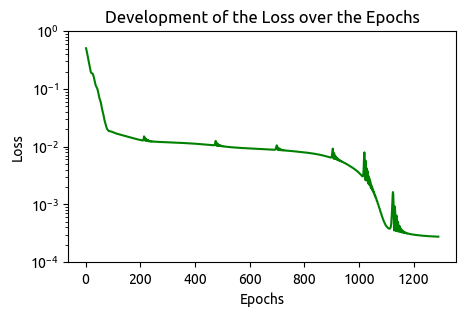

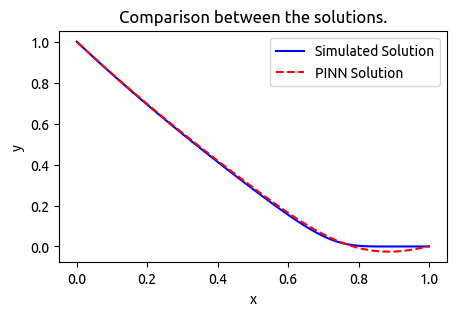

In [ ]:
# Train/Test the model in the smooth case

# Create a model
model5 = create_model(3, 50)

# Create closure function to set alpha and use same fitting function
def loss(model, inp, x_bc, y_bc):
    return oneD_loss(model, inp, x_bc, y_bc, alph_smooth)

# Train the model for the nosy y-data if it is not already trained
try:
    # To force retraining of the model uncomment follwing line
    ## raise Exception

    model5 = keras.models.load_model('./data/simp_mat_var_smooth.keras')
except Exception as e:
    error_time = train(model5, x_train, x_bc, y_bc, loss, lr_schedule, threshold=1e-8)
    model5.save('./data/simp_mat_var_smooth.keras')

    # Create a graph showing the loss vs the epochs
    x, y = zip(*error_time)
    y_order = np.floor(np.log10(np.min(y)))
    plt.figure(figsize=(5, 3))
    plt.plot(x, y, 'g-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.ylim(10**y_order, 1)
    plt.title('Development of the Loss over the Epochs')
    plt.show()


# Visually compare the model with the analytical solution
y_pred5 = model5(x_test).numpy()
# Simulate y_true --> use x_train for simulation as it is smaller
y_true_sim = simp_sim(x_train, y_bc, alph=alph_smooth)[0]

plt.figure(figsize=(5, 3))
plt.plot(x_train, y_true_sim, 'b-', label="Simulated Solution")
plt.plot(x_test, y_pred5, 'r--', label='PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison between the solutions.')
plt.show()

As observed, the discontinuous function results in a _similarly_ discontinuous output in the simulation, while the results from the PINN do **not** align with this behavior. Additionally, the loss of the PINN model remains relatively **high**, indicating that the model **did not converge** to the correct solution.
The underlying issue stems from the _discontinuity itself_. Although PINNs have the potential to approximate discontinuous functions effectively, achieving convergence to these functions can be **challenging**. Accurate results may require careful consideration of the training process, including the design of the loss function, the selection of training data, and the network architecture.
In cases where discontinuities are significant, additional techniques or modifications may be necessary to enhance the performance of the PINN.
For more information about the topic of **discontinuity removing PINNs (DR-PINNs)**, consult e.g. these papers: [Arxiv](https://arxiv.org/abs/2206.03864), [Springer](https://link.springer.com/article/10.1007/s10915-023-02412-1) or [Elsevier](https://www.sciencedirect.com/science/article/abs/pii/S0045782524008910).


In contrast, the results from the smooth function indicate that the model **did** converge properly to the correct solution. However, a noticeable deviation appears in the lower right part of the output, which is _also_ present in the discontinuous model.


This deviation can be attributed to a specific instance of the **vanishing gradient problem**. As both diffusion functions approach zero, the multiplication of this function with the second term of the differential equation effectively _removes_ that term from the calculations. Consequently, the error calculation at these points becomes inaccurate (too low, thus the corresponding gradient is reduced), leading the model to learn an incorrect function. Such problems are **ill-posed** for PINNs.
**It is crucial to ensure that all terms of the differential equation persist throughout the training process.** As such, it must be guaranteed, that no functions can go to zero if they are a multiplicand in the loss terms.


One way to address this issue here is by changing the sigmoid function to not approach zero, by either reducing the k-factor to 6 and below or by manually adjusting the function (in the problematic ranges), for example, by adding a constant value. However, when using the latter option, it is important to ensure that the magnitude of the error generated does _not_ become excessively large compared to the other loss terms or that _no discontinuities_ are generated.
Furthermore, both options are changing the learnig target.
While similar adjustments can be made for the discontinuous function, they are unlikely to improve convergence for the reasons mentioned earlier.